# Modules and helper functions

In [1]:
import os as os
import warnings

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable

import sys as sys
import time as time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import arviz as az
    import pymc3 as pm
    import theano.tensor as tt
    import theano
    

from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import odeint
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy import integrate

save_folder = "figures/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [3]:
def lotVol(x, t, g1, g12, g2, g21):
  # Example from https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
  x1, x2 = x
  dydt = [x1*(g1-g12*x2), x2*(-g2+g21*x1)]
  return dydt

def solve_lotvol(f,x0,t,g1,g12,g2,g21):
  return integrate.odeint(f, x0, t, args = (g1, g12, g2, g21))


def get_time(time_config):
  # Generate the time steps
  T_max = time_config[0]
  size = time_config[1]

  t = np.linspace(0, T_max, size)
  return t

In [4]:
def my_loglik2(theta, data, T_max, sigma = 1.0):
  """
  This returns the log-likelihood of my_model given theta,
  datapoints, the observed data and sigma. It uses the
  model_wrapper function to do a model solve.
  """
  theta = np.array(theta).flatten()
  g1,g12,g2,g21 = theta

  # Set the quadrature points..
  t = np.linspace(0, T_max, data.shape[0])

  # Set initial conditions
  x0=[4,2]

  # Solve system
  output = solve_lotvol(lotVol, x0, t, g1, g12, g2, g21)

  # Get likelihood
  likelihood = -(0.5 / sigma ** 2) * np.sum((output - data) ** 2) # negative log likelihood for gaussian

  return likelihood
# In order to use the likelihood in PyMc we need a Theano Ops function
class LogLike2(tt.Op):
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, T_max, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.T_max = T_max
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):

        theta = inputs

        logl = self.likelihood(theta, self.data, self.T_max, self.sigma)
        outputs[0][0] = np.array(logl)  # output the log-likelihood

# Level comparison test

In [31]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "comparison of methods/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters

g1_true = 2.5
g12_true = 1.5
g2_true = 2
g21_true = 1

y0 = [4,2]

# Generate training data
T_max = 5
size = 500
time_config = [T_max, size]
t = get_time(time_config)
x_true = solve_lotvol(lotVol, y0, t, g1_true, g12_true, g2_true, g21_true)

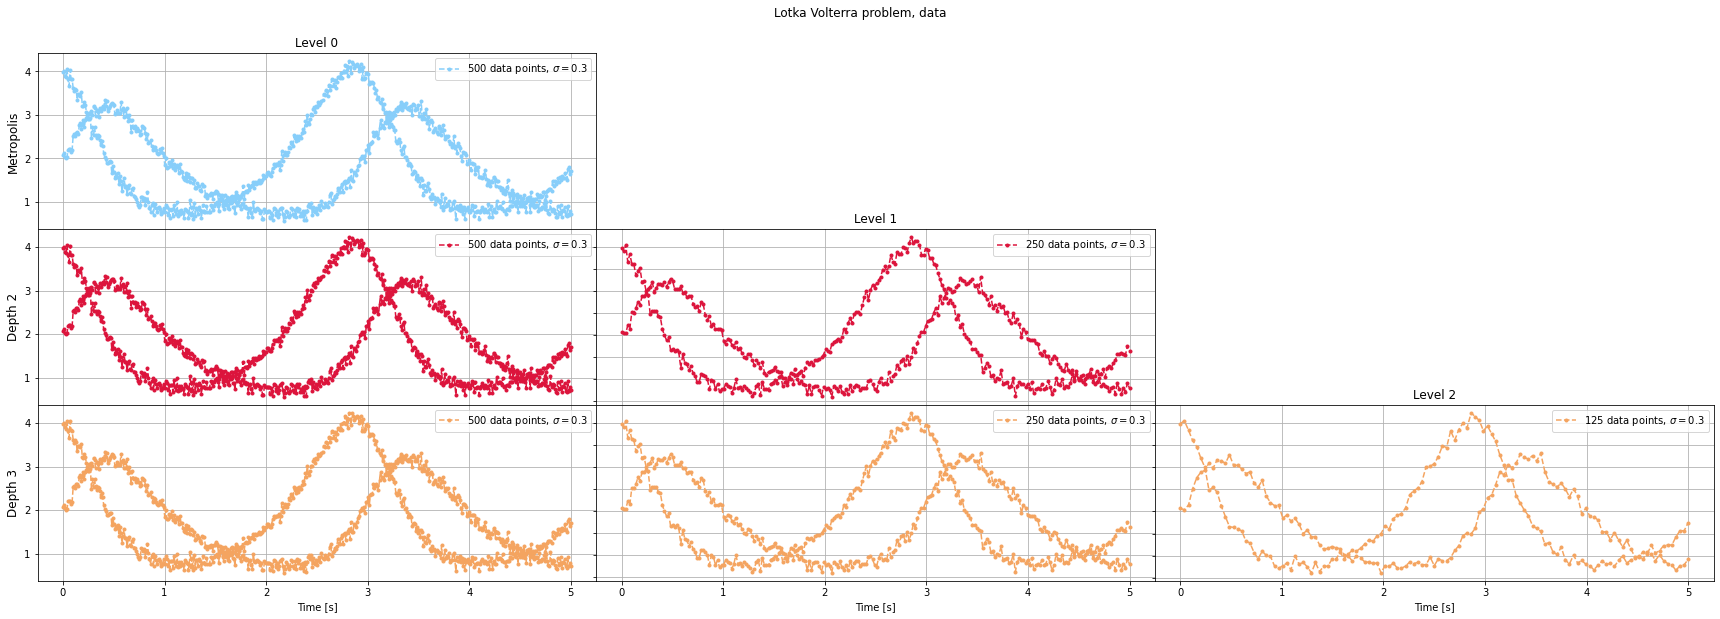

In [32]:
datasets = []
method_names = []

# Add noise
sigma = 0.3
x_noisy = x_true + np.random.normal(0, sigma ** 2, x_true.shape)

#Dataset 1
dataset = []
dataset.append(x_noisy)
datasets.append(dataset)
method_names.append("Metropolis")

#Dataset 2
dataset = []
dataset.append(x_noisy)
dataset.append(x_noisy[::2])
datasets.append(dataset)
method_names.append("Depth 2")

#Dataset 3
dataset = []
dataset.append(x_noisy)
dataset.append(x_noisy[::2])
dataset.append(x_noisy[::4])
datasets.append(dataset)
method_names.append("Depth 3")


cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen", "red"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data[:,0],'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data[:,1],'--.',color = cols[i])
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Lotka Volterra problem, data")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [33]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike2(my_loglik2, data, T_max, sigma = 0.7))
  logls.append(logl)

Create coarse models

In [34]:
# Set prior parameters for multivariate Gaussian prior distribution.
# True = [2.5, 1.5, 2, 1]
# mu_prior = np.array([2.5,1.5,2,1])
mu_prior = np.array([3, 3, 3, 2])
cov_prior = np.eye(4)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(4,))
          #theta = pm.Uniform("theta", lower = 0.1, upper = 10, shape = 4)

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  all_coarse_models.append(coarse_models)

[]
[<pymc3.model.Model object at 0x7f20a267db90>, <pymc3.model.Model object at 0x7f20b7f41610>]


Create fine models

In [35]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:

    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(4,))
    #theta = pm.Uniform("theta", lower = 0.1, upper = 10, shape = 4)

    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [36]:
# Number of draws from the distribution
ndraws = 1000

# Number of independent chains.
nchains = 2

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [5,5]   

In [37]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    if i == 0:
      MAP = pm.find_MAP()

  
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws*70, #adjusting samples to ensure equal runtime
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          return_inferencedata=False,
           start=MAP,
          )
    elif len(coarse_models) == 1:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          ) 
      trace = pm.sample(draws=ndraws*11, #adjusting samples to ensure equal runtime
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                         start=MAP,
                        )
    elif len(coarse_models) == 2:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                         start=MAP,
                        )  
  runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Multiprocess sampling (2 chains in 10 jobs)
Metropolis: [theta]


metropolis 50000


Sampling 2 chains for 1_000 tune and 70_000 draw iterations (2_000 + 140_000 draws total) took 522 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (2 chains in 10 jobs)
MLDA: [theta]


MLDA lvl 2 11000


Sampling 2 chains for 1_000 tune and 11_000 draw iterations (2_000 + 22_000 draws total) took 583 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (2 chains in 10 jobs)
MLDA: [theta]


MLDA lvl 3 1000


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 529 seconds.
The number of effective samples is smaller than 25% for some parameters.


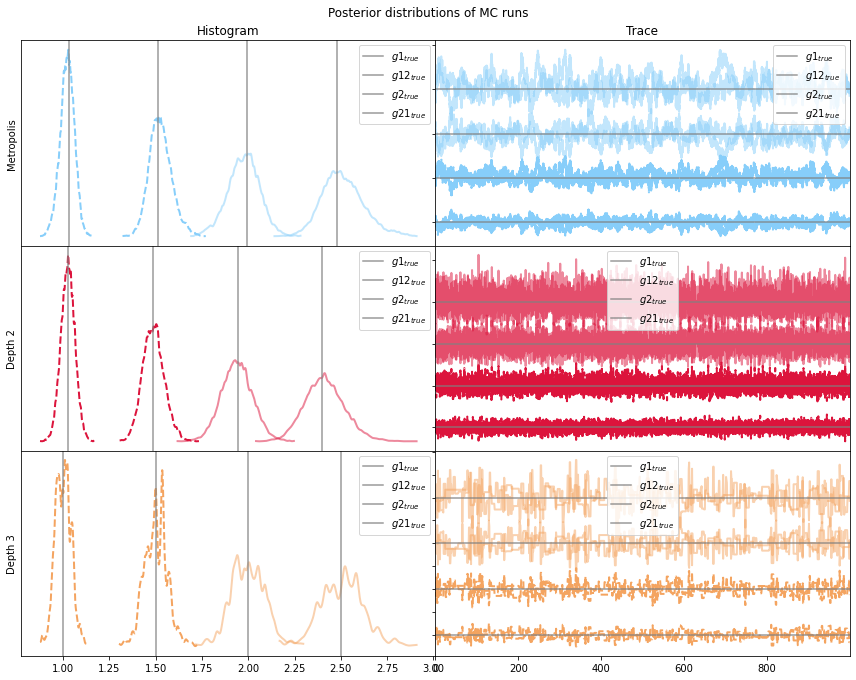

In [38]:
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i]]}
    compact_prop={"lw": [2,2], "ls": ("-", "--"),"alpha":[0.5, 1.0]}
    az.plot_trace(trace, axes = ax[None,i,:], compact = True, combined=True, compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])

    ax[i,0].set_title("")
    ax[i,1].set_title("")

    ax[i,0].axvline(x=g1_true,color="grey",alpha = 0.8, label=r"$g1_{true}$")
    ax[i,0].axvline(x=g12_true,color="grey",alpha = 0.8, label=r"$g12_{true}$")
    ax[i,0].axvline(x=g2_true,color="grey",alpha = 0.8, label=r"$g2_{true}$")
    ax[i,0].axvline(x=g21_true,color="grey",alpha = 0.8, label=r"$g21_{true}$")

    ax[i,1].axhline(y=g1_true,color="grey",alpha = 0.8, label=r"$g1_{true}$")
    ax[i,1].axhline(y=g12_true,color="grey",alpha = 0.8, label=r"$g12_{true}$")
    ax[i,1].axhline(y=g2_true,color="grey",alpha = 0.8, label=r"$g2_{true}$")
    ax[i,1].axhline(y=g21_true,color="grey",alpha = 0.8, label=r"$g21_{true}$")

    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [39]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Metropolis Sampler:
 runtime :  522.8661246299744


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],2.534,0.115,2.324,2.757,0.010,0.007,150.0,214.0,1.02
theta[1],1.515,0.062,1.397,1.633,0.005,0.004,164.0,243.0,1.02
theta[2],1.979,0.088,1.810,2.146,0.007,0.005,151.0,223.0,1.02
theta[3],0.993,0.040,0.918,1.069,0.003,0.002,173.0,265.0,1.02



Depth 2 Sampler:
 runtime :  583.7042546272278


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],2.513,0.117,2.293,2.732,0.002,0.001,4739.0,6163.0,1.0
theta[1],1.504,0.063,1.385,1.624,0.001,0.001,4639.0,6250.0,1.0
theta[2],1.996,0.092,1.830,2.174,0.001,0.001,4822.0,6144.0,1.0
theta[3],1.000,0.041,0.923,1.078,0.001,0.000,5231.0,6113.0,1.0



Depth 3 Sampler:
 runtime :  529.7930147647858


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],2.509,0.117,2.294,2.725,0.006,0.004,434.0,490.0,1.0
theta[1],1.501,0.063,1.397,1.627,0.003,0.002,422.0,443.0,1.0
theta[2],1.999,0.092,1.826,2.161,0.004,0.003,423.0,543.0,1.0
theta[3],1.000,0.042,0.926,1.078,0.002,0.002,399.0,508.0,1.0


In [40]:
# Model predictions
error = []
x_hats = []
for theta_hat in theta_hats:
  x_hat = solve_lotvol(lotVol, y0, t, theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3])
  mse = np.mean((x_true-x_hat)**2)
  x_hats.append(x_hat)
  error.append(mse)


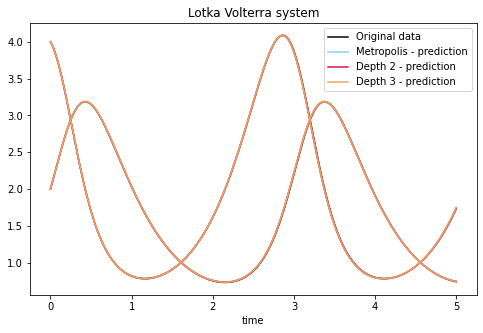

In [42]:
f,ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(t,x_true[:,0],'-k',label="Original data")
ax.plot(t,x_true[:,1],'-k')
for i,x_hat in enumerate(x_hats):
  ax.plot(t,x_hat[:,0],'-',color=cols[i], label=method_names[i] + " - prediction")
  ax.plot(t,x_hat[:,1],'-',color=cols[i])
ax.legend()
ax.set_xlabel("time")
ax.set_title("Lotka Volterra system")

plt.show()
f.savefig(image_folder + "predictions.png",bbox_inches='tight',dpi=300)

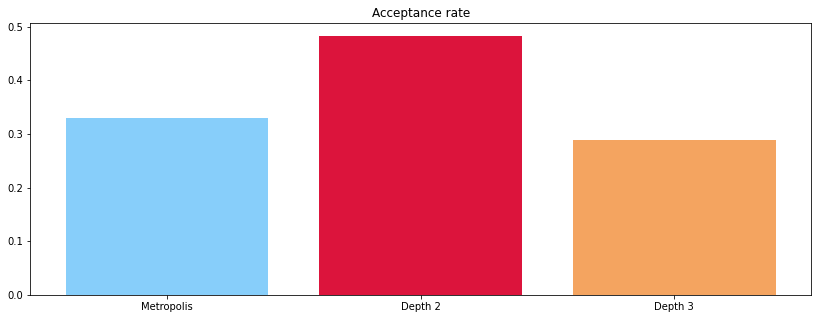

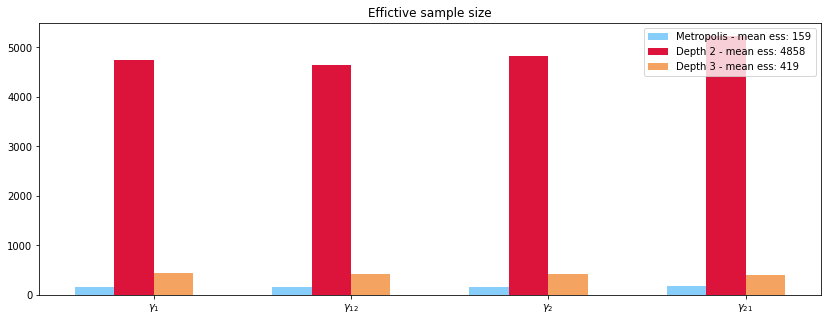

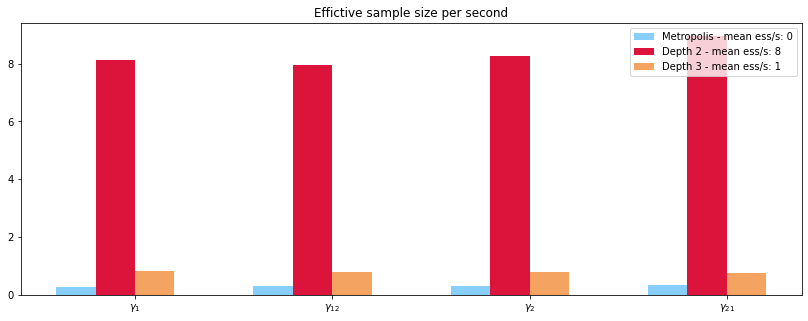

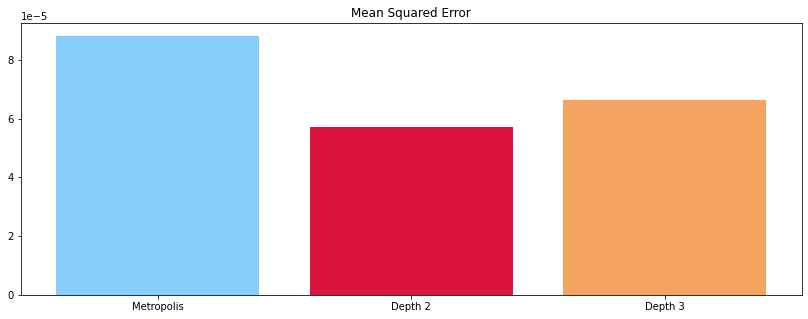

In [43]:
# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen", "red"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)




f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size')
for i, e in enumerate(ess):
  e_new = np.concatenate((e,np.zeros(ess[-1].shape[0]-e.shape[0])))
  ax.bar(
      [j + i * 0.2 for j in range(4)],
      e_new.ravel(),
      width=0.2,
      color=cols[i],
      label=method_names[i]+ f" - mean ess: {round(np.mean(e))}",
  )
ax.set_xticks([i + 0.3 for i in range(4)])
ax.set_xticklabels([rf"$\gamma_1$",rf"$\gamma_{{12}}$",rf"$\gamma_2$",rf"$\gamma_{{21}}$"])
ax.legend()
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)




f,ax = plt.subplots(figsize=(14,5))
ax.set_title('Effictive sample size per second')
for i, p in enumerate(performances):
  p_new = np.concatenate((p,np.zeros(performances[-1].shape[0]-p.shape[0])))
  ax.bar(
      [j + i * 0.2 for j in range(4)],
      p_new.ravel(),
      width=0.2,
      color=cols[i],
      label=method_names[i]+ f" - mean ess/s: {round(np.mean(p))}",
  )
ax.set_xticks([i + 0.3 for i in range(4)])
ax.set_xticklabels([rf"$\gamma_1$",rf"$\gamma_{{12}}$",rf"$\gamma_2$",rf"$\gamma_{{21}}$"])
ax.legend()
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)